<a href="https://colab.research.google.com/github/ShahazadAbdulla/product-label-quality-ml/blob/main/label_quality_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
from google.colab import drive

# Check for GPU
print("--- GPU Check ---")
gpu_name = tf.test.gpu_device_name()
if gpu_name:
    print(f"Found GPU: {gpu_name}")
    print("TensorFlow version:", tf.__version__)
else:
    print("No GPU found. Please ensure you've selected a GPU runtime.")

# Mount Google Drive
print("\n--- Google Drive Mount ---")
drive.mount('/content/drive', force_remount=True) #
print("Google Drive mounted successfully at /content/drive")

--- GPU Check ---
Found GPU: /device:GPU:0
TensorFlow version: 2.18.0

--- Google Drive Mount ---
Mounted at /content/drive
Google Drive mounted successfully at /content/drive


In [5]:
import os

print("--- Defining Dataset Paths ---")
base_drive_path = '/content/drive/MyDrive/IntelUnnatiProject/ML_Label_Quality'
dataset_base_dir = os.path.join(base_drive_path, ' dataset')

train_dir = os.path.join(dataset_base_dir, 'train')
validation_dir = os.path.join(dataset_base_dir, 'validation')
test_dir = os.path.join(dataset_base_dir, 'test')

print(f"Base dataset directory: {dataset_base_dir}")
print(f"Training directory: {train_dir}")
print(f"Validation directory: {validation_dir}")
print(f"Test directory: {test_dir}")

print("\n--- Verifying Directory Existence and Image Counts ---")

def check_and_count_images(directory_path, dir_name_label):
    if not os.path.exists(directory_path):
        print(f"ERROR: {dir_name_label} directory does not exist: {directory_path}")
        return False, 0, 0

    good_labels_path = os.path.join(directory_path, 'good_labels')
    bad_labels_path = os.path.join(directory_path, 'bad_labels')

    if not os.path.exists(good_labels_path):
        print(f"ERROR: 'good_labels' subdirectory not found in {directory_path}")
        return True, 0, 0
    if not os.path.exists(bad_labels_path):
        print(f"ERROR: 'bad_labels' subdirectory not found in {directory_path}")
        return True, 0, 0

    num_good = len(os.listdir(good_labels_path))
    num_bad = len(os.listdir(bad_labels_path))

    print(f"In {dir_name_label} ('{os.path.basename(directory_path)}'):")
    print(f"  Found {num_good} images in 'good_labels'")
    print(f"  Found {num_bad} images in 'bad_labels'")
    print(f"  Total in {dir_name_label}: {num_good + num_bad} images")
    if num_good == 0 or num_bad == 0:
        print(f"  WARNING: One of the classes in {dir_name_label} has 0 images. This will cause problems.")
    return True, num_good, num_bad

dir_exists, num_train_good, num_train_bad = check_and_count_images(train_dir, "Training")
_, num_val_good, num_val_bad = check_and_count_images(validation_dir, "Validation")
_, num_test_good, num_test_bad = check_and_count_images(test_dir, "Test")

total_train_images = num_train_good + num_train_bad
if total_train_images < 20:
    print(f"\nWARNING: You have only {total_train_images} training images. Consider adding more for better model performance.")

--- Defining Dataset Paths ---
Base dataset directory: /content/drive/MyDrive/IntelUnnatiProject/ML_Label_Quality/ dataset
Training directory: /content/drive/MyDrive/IntelUnnatiProject/ML_Label_Quality/ dataset/train
Validation directory: /content/drive/MyDrive/IntelUnnatiProject/ML_Label_Quality/ dataset/validation
Test directory: /content/drive/MyDrive/IntelUnnatiProject/ML_Label_Quality/ dataset/test

--- Verifying Directory Existence and Image Counts ---
In Training ('train'):
  Found 45 images in 'good_labels'
  Found 45 images in 'bad_labels'
  Total in Training: 90 images
In Validation ('validation'):
  Found 15 images in 'good_labels'
  Found 15 images in 'bad_labels'
  Total in Validation: 30 images
In Test ('test'):
  Found 15 images in 'good_labels'
  Found 15 images in 'bad_labels'
  Total in Test: 30 images


In [6]:
import tensorflow as tf
print("--- Defining Imaging and data parameter ---")
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 8

print(f"Target image size: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")


--- Defining Imaging and data parameter ---
Target image size: (224, 224)
Batch size: 8


In [7]:
print("--- Loading Datasets ---")

# Load Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMAGE_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)
print(f"Loaded training dataset. Found {tf.data.experimental.cardinality(train_ds).numpy()} batches of data.")

# Load Validation Dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMAGE_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=False             # No need to shuffle validation data
)
print(f"Loaded validation dataset. Found {tf.data.experimental.cardinality(validation_ds).numpy()} batches of data.")

# Load Test Dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMAGE_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=False             # No need to shuffle test data
)
print(f"Loaded test dataset. Found {tf.data.experimental.cardinality(test_ds).numpy()} batches of data.")

class_names = train_ds.class_names
print(f"\nClass names inferred: {class_names}")
if class_names[0] == 'bad_labels': # Assuming 'bad_labels' comes first alphabetically
    print("Mapping: bad_labels -> 0, good_labels -> 1")
else:
    print("Mapping: good_labels -> 0, bad_labels -> 1")


# Let's inspect a batch from the training dataset
print("\n--- Inspecting a Batch from Training Dataset ---")
for images, labels in train_ds.take(1):  # Take one batch
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    print("Labels type:", labels.dtype)
    print("First 5 labels in the batch:", labels.numpy()[:5].flatten())
    print("Image data type:", images.dtype)   # Expected: tf.float32 (pixels 0-255)
    print("Min pixel value:", tf.reduce_min(images[0]).numpy()) # Check range
    print("Max pixel value:", tf.reduce_max(images[0]).numpy()) # Check range

--- Loading Datasets ---
Found 90 files belonging to 2 classes.
Loaded training dataset. Found 12 batches of data.
Found 30 files belonging to 2 classes.
Loaded validation dataset. Found 4 batches of data.
Found 30 files belonging to 2 classes.
Loaded test dataset. Found 4 batches of data.

Class names inferred: ['bad_labels', 'good_labels']
Mapping: bad_labels -> 0, good_labels -> 1

--- Inspecting a Batch from Training Dataset ---
Images batch shape: (8, 224, 224, 3)
Labels batch shape: (8, 1)
Labels type: <dtype: 'float32'>
First 5 labels in the batch: [0. 0. 0. 0. 1.]
Image data type: <dtype: 'float32'>
Min pixel value: 0.0
Max pixel value: 255.0


In [8]:
print("--- Configuring Datasets for Performance ---")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000, seed=42, reshuffle_each_iteration=True).prefetch(buffer_size=AUTOTUNE)

# Apply to validation dataset
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Apply to test dataset
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Datasets configured with .cache() and .prefetch()")
print(f"Training dataset: {train_ds}")
print(f"Validation dataset: {validation_ds}")
print(f"Test dataset: {test_ds}")

--- Configuring Datasets for Performance ---
Datasets configured with .cache() and .prefetch()
Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [9]:
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential


print("--- Defining Data Augmentation Layers (Keras Input Style) ---")
data_augmentation = Sequential(
    [
        Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(factor=0.3),
        layers.RandomBrightness(factor=0.2)
    ],
    name="data_augmentation_v2"
)
print("Data augmentation pipeline created:")
data_augmentation.summary()

--- Defining Data Augmentation Layers (Keras Input Style) ---
Data augmentation pipeline created:


Model: "data_augmentation_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 224, 224, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

--- Visualizing a Batch of Original and Augmented Images ---


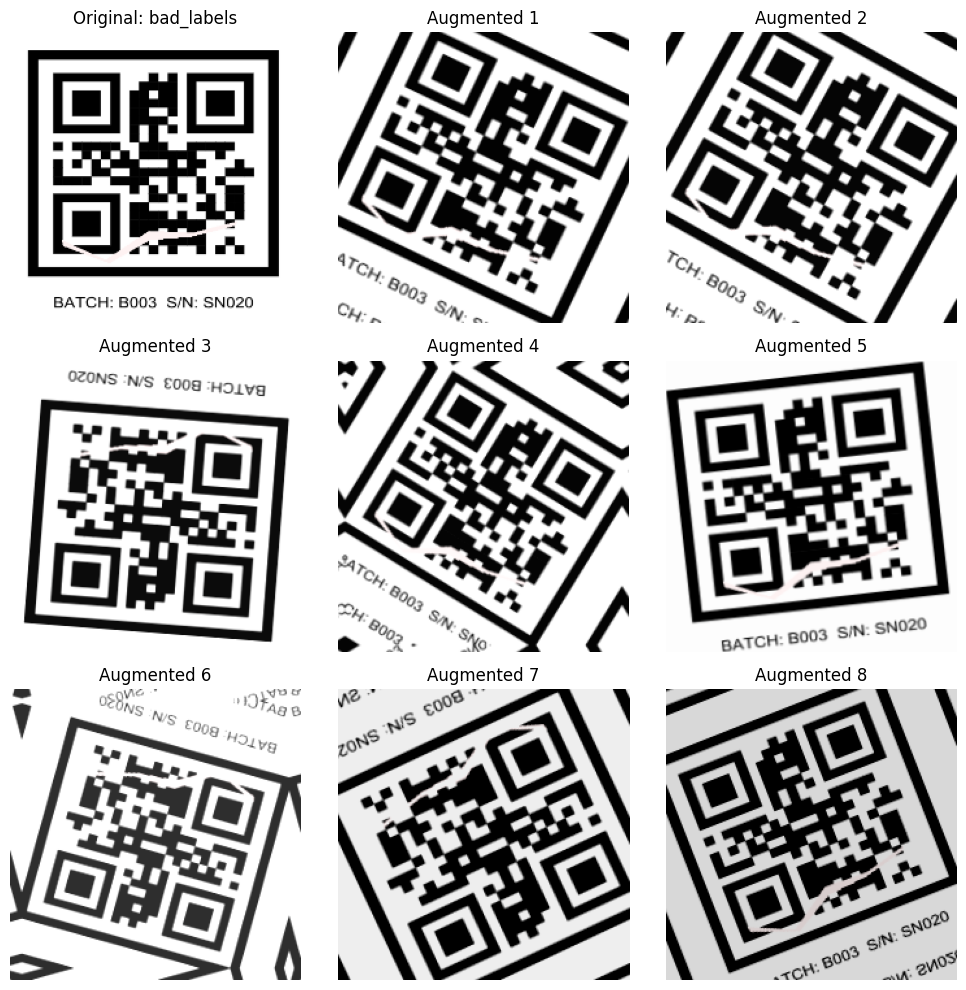

In [10]:
import matplotlib.pyplot as plt

print("--- Visualizing a Batch of Original and Augmented Images ---")

for images, labels in train_ds.take(1):  # Get one batch
    original_image = images[0]

    plt.figure(figsize=(10, 10))
    # Display the original image
    ax = plt.subplot(3, 3, 1)
    plt.imshow(original_image.numpy().astype("uint8")) # Cast to uint8 if needed for imshow
    plt.title(f"Original: {class_names[int(labels[0].numpy().item())]}")
    plt.axis("off")

    # Display 8 augmented versions of the same image
    for i in range(8):
        ax = plt.subplot(3, 3, i + 2)
        augmented_image = data_augmentation(tf.expand_dims(original_image, 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(f"Augmented {i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

In [11]:
import tensorflow as tf

print(f"--- Loading MobileNetV2 Base Model with IMAGE_SIZE: {IMAGE_SIZE} ---")

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

print("MobileNetV2 base model loaded.")

--- Loading MobileNetV2 Base Model with IMAGE_SIZE: (224, 224) ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MobileNetV2 base model loaded.


In [12]:
print("--- Freezing the Base Model (MobileNetV2) ---")
base_model.trainable = False
print(f"Base model 'trainable' attribute set to: {base_model.trainable}")
print("Trainable status of some layers in base_model:")
for layer in base_model.layers[:5]:
  print(f"{layer.name}: {layer.trainable}")

--- Freezing the Base Model (MobileNetV2) ---
Base model 'trainable' attribute set to: False
Trainable status of some layers in base_model:
input_layer_1: False
Conv1: False
bn_Conv1: False
Conv1_relu: False
expanded_conv_depthwise: False


In [13]:
from tensorflow.keras import layers, Model, Input # Ensure Input is imported

print("--- Building the Full Model with Transfer Learning ---")

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input_layer")
x = data_augmentation(inputs, training=None)

x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
print("Applied MobileNetV2 preprocessing.")

# 4. Pass inputs through the frozen base model
# 'training=False' here ensures that even if base_model.trainable is True later
# (for fine-tuning), batch normalization layers in MobileNetV2 run in inference mode
# when using the frozen base. This is important for stable fine-tuning.
x = base_model(x, training=False)
print("Passed data through base_model.")

# 5. Add a Global Average Pooling layer
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
print("Applied GlobalAveragePooling2D.")

# 6. Add a Dropout layer for regularization
x = layers.Dropout(0.2, name="dropout_layer")(x) # Dropout 20% of units
print("Applied Dropout.")

# 7. Add the final classification layer
# Dense layer with 1 unit (for binary classification) and sigmoid activation
outputs = layers.Dense(1, activation='sigmoid', name="output_layer")(x)
print("Added output Dense layer with sigmoid activation.")

# Create the final model
model = Model(inputs=inputs, outputs=outputs, name="label_quality_classifier")

print("\n--- Full Model Summary ---")
model.summary()

--- Building the Full Model with Transfer Learning ---
Applied MobileNetV2 preprocessing.
Passed data through base_model.
Applied GlobalAveragePooling2D.
Applied Dropout.
Added output Dense layer with sigmoid activation.

--- Full Model Summary ---


Model: "label_quality_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_v2            │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
print("--- Compiling the Model ---")


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("Model compiled successfully.")

--- Compiling the Model ---
Model compiled successfully.


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

print("--- Setting up ModelCheckpoint Callback for Balanced Frozen Training ---")
checkpoint_filepath_balanced_frozen = '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/best_model_balanced_frozen.weights.h5'

model_checkpoint_callback_bf = ModelCheckpoint(
    filepath=checkpoint_filepath_balanced_frozen,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
    )
print(f"ModelCheckpoint configured to save best weights to: {checkpoint_filepath_balanced_frozen}")


--- Setting up ModelCheckpoint Callback for Balanced Frozen Training ---
ModelCheckpoint configured to save best weights to: /content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/best_model_balanced_frozen.weights.h5


In [16]:
print("--- Starting Training on Balanced Dataset (Frozen Base) ---")
# With more data, you can try more epochs or see if it converges well with 20-25
epochs_balanced_frozen = 25 # Let's try 25 epochs

history_balanced_frozen = model.fit(
      train_ds,
      epochs=epochs_balanced_frozen,
      validation_data=validation_ds,
      callbacks=[model_checkpoint_callback_bf] # Add the new callback
  )
print("\n--- Training on Balanced Dataset (Frozen Base) Finished ---")

--- Starting Training on Balanced Dataset (Frozen Base) ---
Epoch 1/25
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3863 - loss: 0.7819
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/best_model_balanced_frozen.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4004 - loss: 0.7767 - val_accuracy: 0.5000 - val_loss: 0.7546
Epoch 2/25
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5008 - loss: 0.7294
Epoch 2: val_accuracy did not improve from 0.50000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5103 - loss: 0.7235 - val_accuracy: 0.5000 - val_loss: 0.7420
Epoch 3/25
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5511 - loss: 0.7038
Epoch 3: val_accuracy did not improve from 0.50000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5603 - loss: 0.6974 - val_accuracy: 0.5000 - val_loss: 0.7352
Epoch 4/25
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc

--- Plotting Balanced Frozen Training and Validation Metrics ---


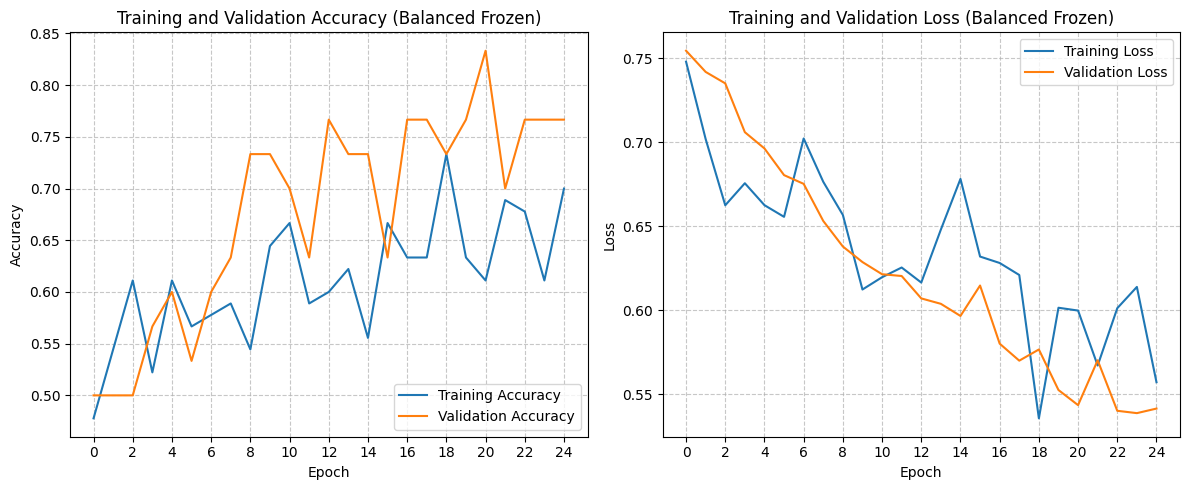


--- Interpreting the Plots ---
1. Good Fit: Training and validation loss decrease and stabilize. Training and validation accuracy increase and stabilize. Validation metrics are close to training metrics.
2. Overfitting: Gap between training and validation loss widens (training loss decreases, validation loss increases or plateaus). Gap between training and validation accuracy widens (training accuracy increases, validation accuracy plateaus or decreases).
3. Underfitting: Both training and validation loss are high and do not decrease much. Both training and validation accuracy are low and do not improve much. The model is too simple or not trained enough.


In [17]:
import matplotlib.pyplot as plt

print("--- Plotting Balanced Frozen Training and Validation Metrics ---") # Updated title for clarity

# Retrieve training history FROM THE CORRECT HISTORY OBJECT
acc = history_balanced_frozen.history['accuracy']        # <--- CHANGE HERE
val_acc = history_balanced_frozen.history['val_accuracy']  # <--- CHANGE HERE
loss = history_balanced_frozen.history['loss']           # <--- CHANGE HERE
val_loss = history_balanced_frozen.history['val_loss']     # <--- CHANGE HERE

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Balanced Frozen)') # Updated title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
if len(epochs_range) > 10:
  plt.xticks(epochs_range[::max(1, len(epochs_range)//10)])
else:
  plt.xticks(epochs_range)
plt.grid(True, linestyle='--', alpha=0.7)


# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Balanced Frozen)') # Updated title
plt.xlabel('Epoch')
plt.ylabel('Loss')
if len(epochs_range) > 10:
  plt.xticks(epochs_range[::max(1, len(epochs_range)//10)])
else:
  plt.xticks(epochs_range)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\n--- Interpreting the Plots ---")
print("1. Good Fit: Training and validation loss decrease and stabilize. Training and validation accuracy increase and stabilize. Validation metrics are close to training metrics.")
print("2. Overfitting: Gap between training and validation loss widens (training loss decreases, validation loss increases or plateaus). Gap between training and validation accuracy widens (training accuracy increases, validation accuracy plateaus or decreases).")
print("3. Underfitting: Both training and validation loss are high and do not decrease much. Both training and validation accuracy are low and do not improve much. The model is too simple or not trained enough.")

In [ ]:
print("--- Evaluating Model on Test Dataset ---")

test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

# Save only the weights of the model
weights_path = '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/label_quality_classifier_weights.weights.h5'
model.save_weights(weights_path)
print(f"Model weights saved to: {weights_path}")

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({(test_accuracy*100):.2f}%)")

--- Evaluating Model on Test Dataset ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 811ms/step - accuracy: 0.4333 - loss: 0.7097
Model weights saved to: /content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/label_quality_classifier_weights.weights.h5

Test Loss: 0.7144
Test Accuracy: 0.4000 (40.00%)


In [18]:
print("--- Loading Best Weights from Balanced Frozen Training ---")

# This should be the filepath you used for ModelCheckpoint in the last training run
checkpoint_filepath_balanced_frozen = '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/best_model_balanced_frozen.weights.h5'

model.load_weights(checkpoint_filepath_balanced_frozen)
print(f"Loaded best weights from: {checkpoint_filepath_balanced_frozen}")
# Now, your 'model' object in memory has the weights from the epoch with the highest val_accuracy

--- Loading Best Weights from Balanced Frozen Training ---
Loaded best weights from: /content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/best_model_balanced_frozen.weights.h5


In [ ]:
print("--- Saving the Trained Model (TensorFlow SavedModel format for Keras 3) ---")

# Define the path to save the model in your Google Drive
# For SavedModel, you provide a directory path. TensorFlow will create files inside it.
# model_sm_save_path = '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/label_quality_classifier_initial_frozen_sm' # Directory path

# Use the recommended .keras format for saving the model with Keras 3
model_keras_save_path = '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/label_quality_classifier_initial_frozen.keras' # File path with .keras extension

# Save the model
model.save(model_keras_save_path)

print(f"Model saved in native Keras format to: {model_keras_save_path}")

--- Saving the Trained Model (TensorFlow SavedModel format for Keras 3) ---
Model saved in native Keras format to: /content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/label_quality_classifier_initial_frozen.keras


In [19]:
# Cell A
print("--- Loading Best Weights from Balanced Frozen Training ---")

# THIS IS THE CORRECT FILENAME that ModelCheckpoint used during the balanced frozen training
checkpoint_filepath_balanced_frozen = '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/best_model_balanced_frozen.weights.h5'
# model_to_test = None # Initialize to None

try:
    model.load_weights(checkpoint_filepath_balanced_frozen) # Load the best weights into the current 'model'
    print(f"Successfully loaded best weights from: {checkpoint_filepath_balanced_frozen}")
    # 'model' now has the best weights.
    # model_to_test = model # No need for a separate variable if 'model' is updated
except Exception as e:
    print(f"Error loading weights from checkpoint: {e}")
    print("Please ensure the checkpoint_filepath is correct and the file exists.")
    # print("Falling back to the model from the last epoch of re-training (if needed for testing).")
    # model_to_test = model # We want to ensure we test the best, so if loading fails, we should stop or investigate.

--- Loading Best Weights from Balanced Frozen Training ---
Successfully loaded best weights from: /content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/best_model_balanced_frozen.weights.h5


In [20]:
# Cell B (This is the one you showed as the "next cell" in your screenshot)
print("--- Saving Best Balanced Frozen Model ---") # Updated title for clarity

# Use a descriptive name for the Keras model file
model_keras_save_path = '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/label_classifier_balanced_frozen_best.keras'

# Save the model (which now contains the best weights loaded by Cell A)
model.save(model_keras_save_path)

print(f"Model saved in native Keras format to: {model_keras_save_path}")

--- Saving Best Balanced Frozen Model ---
Model saved in native Keras format to: /content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/saved_models/label_classifier_balanced_frozen_best.keras


In [21]:
# Cell C
print("--- Evaluating Best Balanced Frozen Model on Test Dataset ---")
# 'model' currently holds the best weights (loaded in Cell A, saved in Cell B)

test_loss_balanced_f, test_accuracy_balanced_f = model.evaluate(test_ds, verbose=1)

print(f"\nTest Loss (Balanced, Frozen - Best Checkpoint): {test_loss_balanced_f:.4f}")
print(f"Test Accuracy (Balanced, Frozen - Best Checkpoint): {test_accuracy_balanced_f:.4f} ({(test_accuracy_balanced_f*100):.2f}%)")

--- Evaluating Best Balanced Frozen Model on Test Dataset ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7292 - loss: 0.5187

Test Loss (Balanced, Frozen - Best Checkpoint): 0.5137
Test Accuracy (Balanced, Frozen - Best Checkpoint): 0.8333 (83.33%)



--- Testing Individual Images using current 'model' object ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


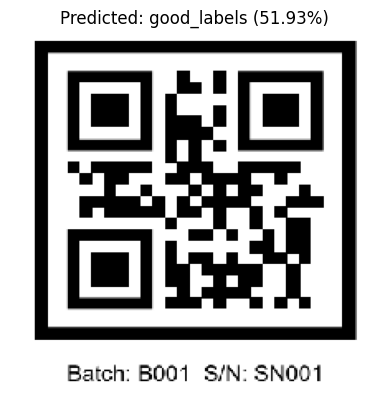

Image: SN001.png
Raw prediction value: 0.5193
Predicted class: good_labels (Index: 1)
Confidence in predicted class: 51.93%
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


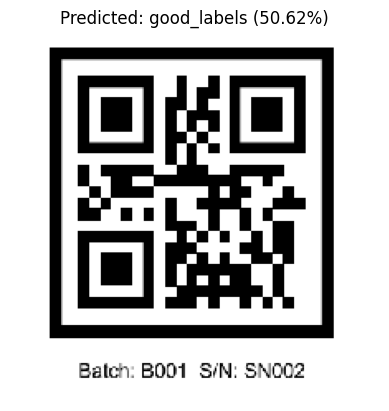

Image: SN002.png
Raw prediction value: 0.5062
Predicted class: good_labels (Index: 1)
Confidence in predicted class: 50.62%
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


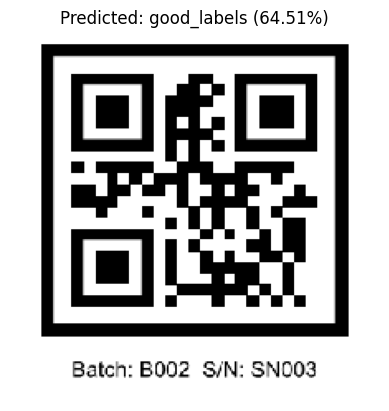

Image: SN003.png
Raw prediction value: 0.6451
Predicted class: good_labels (Index: 1)
Confidence in predicted class: 64.51%
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


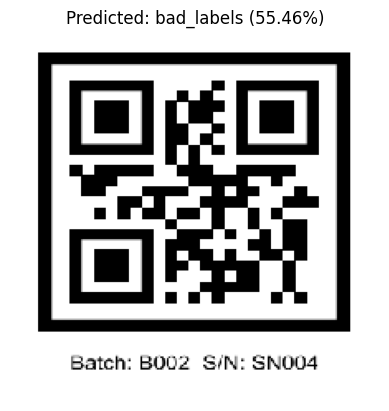

Image: SN004.png
Raw prediction value: 0.4454
Predicted class: bad_labels (Index: 0)
Confidence in predicted class: 55.46%
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


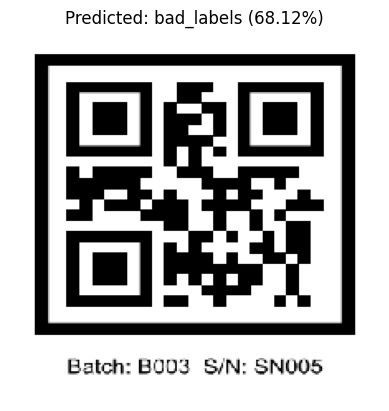

Image: SN005.png
Raw prediction value: 0.3188
Predicted class: bad_labels (Index: 0)
Confidence in predicted class: 68.12%
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


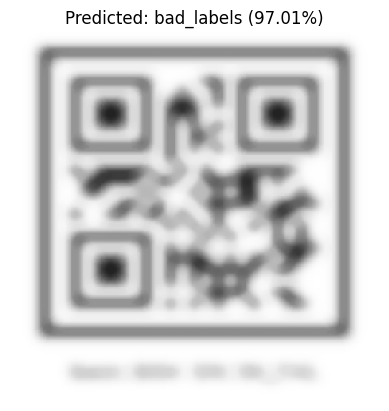

Image: SN_FAIL_BLURRY.png
Raw prediction value: 0.0299
Predicted class: bad_labels (Index: 0)
Confidence in predicted class: 97.01%
------------------------------


In [23]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image_utils
import matplotlib.pyplot as plt

# Ensure these are defined as they were during training
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)

# --- Crucial: Define or Confirm class_names ---
# This should match the output from when you loaded train_ds
# e.g., train_ds.class_names after loading your balanced dataset
# If you are unsure, re-run the cell that loads train_ds and prints its class_names
# For example, if it was Cell 4:
# train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, ...)
# class_names = train_ds.class_names
# print(f"Using class_names: {class_names}") # Should be ['bad_labels', 'good_labels'] or vice-versa

# If you know it for sure from previous runs, you can define it directly:
class_names = ['bad_labels', 'good_labels'] # Assuming bad_labels=0, good_labels=1

def predict_single_image(img_path, model_to_predict_with, class_names_list): # Renamed `model` param
    img = keras_image_utils.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = keras_image_utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    prediction = model_to_predict_with.predict(img_batch) # Use the passed model

    predicted_class_index = int(prediction[0][0] > 0.5)
    predicted_class_name = class_names_list[predicted_class_index]
    confidence_score = prediction[0][0] if predicted_class_index == 1 else 1 - prediction[0][0] # More explicit name

    plt.imshow(img_array.astype("uint8"))
    plt.title(f"Predicted: {predicted_class_name} ({confidence_score*100:.2f}%)")
    plt.axis("off")
    plt.show()

    print(f"Image: {os.path.basename(img_path)}") # Use os.path.basename for cleaner filename
    print(f"Raw prediction value: {prediction[0][0]:.4f}")
    print(f"Predicted class: {predicted_class_name} (Index: {predicted_class_index})")
    print(f"Confidence in predicted class: {confidence_score*100:.2f}%")
    print("-" * 30)
    return predicted_class_name, confidence_score

# List of your image paths (these look good if they exist on your Drive)
image_paths_to_test = [
    '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/label_images_test/SN001.png',
    '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/label_images_test/SN002.png',
    '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/label_images_test/SN003.png',
    '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/label_images_test/SN004.png',
    '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/label_images_test/SN005.png',
    '/content/drive/My Drive/IntelUnnatiProject/ML_Label_Quality/label_images_test/SN_FAIL_BLURRY.png'
]

# --- Test each image using the 'model' object currently in memory ---
# This 'model' object should have had the best weights loaded into it in the PREVIOUS cell.
if 'model' in globals() and isinstance(model, tf.keras.Model): # Check if 'model' exists and is a Keras model
    print(f"\n--- Testing Individual Images using current 'model' object ---")
    # You can also verify which model you are about to use by printing its name or summary
    # print(f"Using model: {model.name}")
    # model.summary() # If you want to be extra sure

    for img_path in image_paths_to_test:
        try:
            # Pass the 'model' object from your Colab session
            predict_single_image(img_path, model, class_names)
        except FileNotFoundError:
            print(f"ERROR: Image not found at {img_path}. Please check the path.")
        except Exception as e:
            print(f"An error occurred while processing {img_path}: {e}")
            import traceback
            traceback.print_exc() # Print full traceback for debugging
else:
    print("ERROR: The Keras 'model' object is not defined or is not a Keras Model.")
    print("Please ensure you have run the cells to define, compile, and load weights into the 'model' object.")